# Домашнее задание: определить качество вина

### Постановка задачи

Мы выступим в роли программиста-сомелье: нам предстоит определять качество вина. Необходимо решить задачу классификации с использованием SVM и подобрать наилучшее ядро.

### Данные

Датасет содержит информацию о красных винах и их составе. Целевой переменной является столбец "quality". Это метрика качества вина по шкале от 3 до 8.

In [36]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
df = pd.read_csv('winequality-red.zip', sep=';')
display(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Все признаки числового типа, пропусков в данных нет.
Проведем анализ данных.

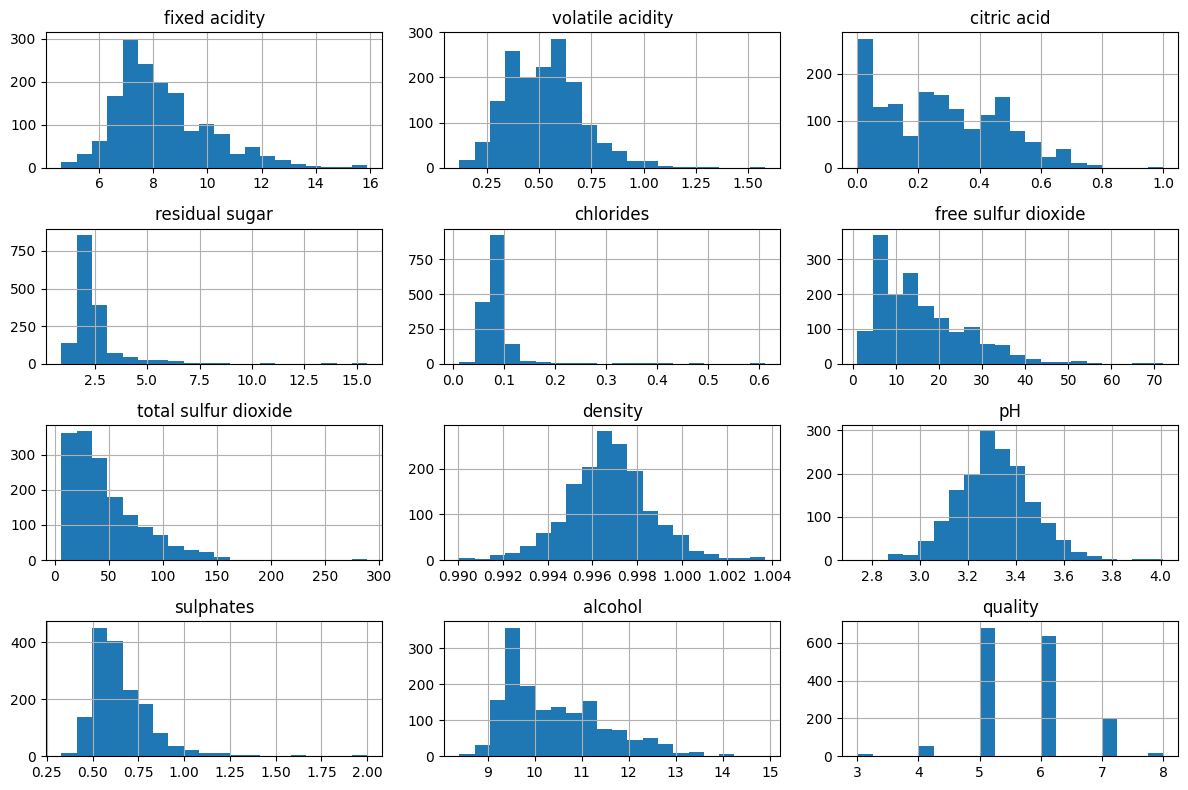

In [12]:
df.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

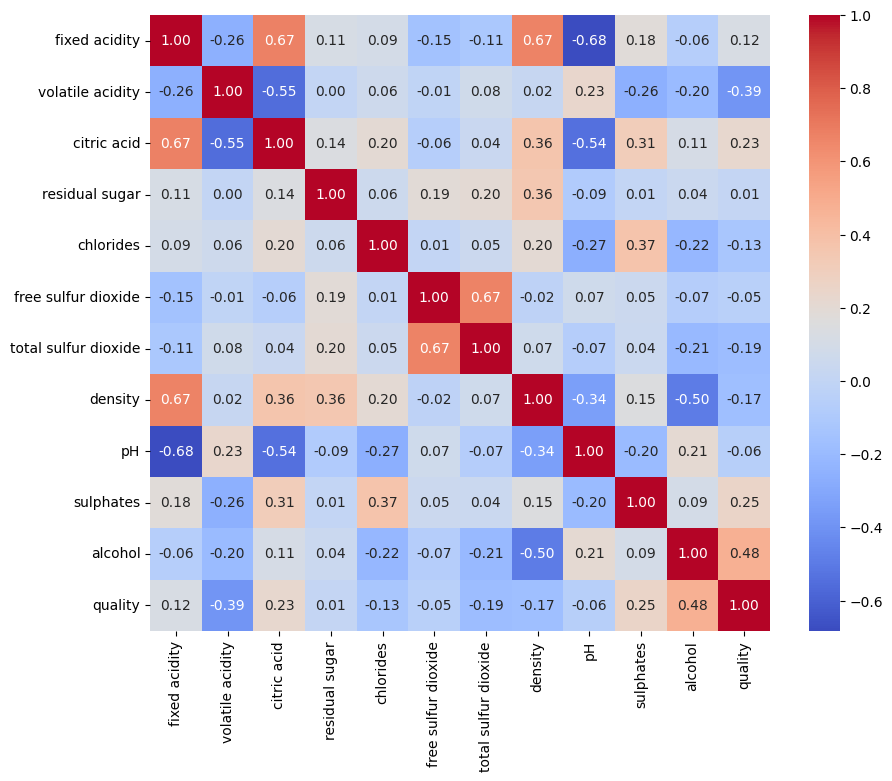

In [13]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

#### Выводы
* гистограммы признаков `density` и `pH` показывают разспределение близкое к нормальному
* целевой признак `quality` является категориальным - заменим его на бинарный, где 1 - хорошее качество ($quality > 6.5$), а 0 - плохое качество ($quality < 6.5$)
* остальные признаки скошены вправо, что говорит о выбрасах при больших значениях
* все признаки слабо коррелируют с целевой переменной, что говорит о нелинейной связи между признаками и целевой переменной
* нет сильной связи между парами признаков (есть средняя связь между некоторыми признаками, например, между `fixed acidity` и `pH`)

In [14]:
df['quality'] = df['quality'].apply(lambda x: 1 if x > 6.5 else 0)
df['quality'].value_counts()

quality
0    1382
1     217
Name: count, dtype: int64

Применим масштабирование данных, поскольку модель SVC чувствительна к масштабу признаков, так как строит оптимальную разделяющую гиперплоскость между классами. Если признаки имеют разные масштабы, более масштабированные признаки будут иметь больший вес в функции расчета расстояний, что может привести к неоптимальной разделяющей гиперплоскости.

In [29]:
y = df['quality']
X = df.drop(['quality'], axis=1)

# Разбиение данных на обучающую и тестовую выборки
# Используем стратифицированное разбиение данных, поскольку классы не сбалансированы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметры для GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],  # Значения C для настройки регуляризации
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100]  # Параметры gamma для нелинейных ядер
}

# Создание модели SVC
model = SVC()

# Настройка GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=2)

# Обучение GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры и лучшая точность
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность: {best_score:.2f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scal

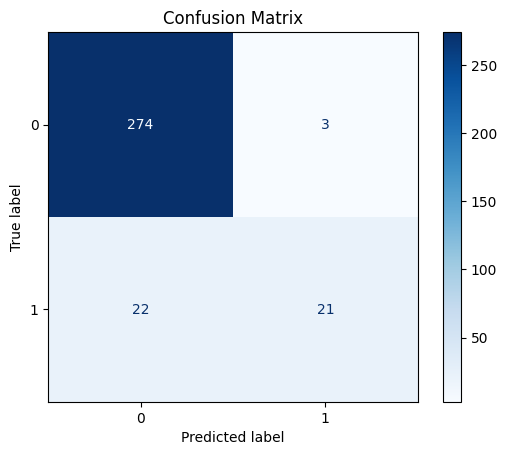

In [30]:
# Получение предсказаний на тестовом наборе данных с использованием лучшей модели
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#### Выводы
* нашли лучшую модель SVC c параметрами {'C': 100, 'gamma': 1, 'kernel': 'rbf'} и точностью 0.90
* модель успешно предсказала 274 случай из 277. Доля правильных предсказаний (True Negative Rate) для этого класса составляет примерно 98.9%.
* очень мало случаев (всего 2), когда модель неправильно присвоила класс 1 (например, высокое качество вина) винам, которые на самом деле принадлежат классу 0. Это указывает на хорошую способность модели избегать ошибок первого рода в этом классе.
* модель предсказала правильно только 21 случаев из 43, что указывает на низкую эффективность модели в правильной классификации вин высокого качества. Доля правильных предсказаний (True Positive Rate) для этого класса составляет примерно 48.8%.
* довольно высокое количество ошибок (22), когда модель предсказала класс 0, в то время как истинный класс был 1. Это указывает на проблемы модели с выявлением вин высокого качества.

In [34]:
# Использование лучшей модели, найденной GridSearchCV
best_model = grid_search.best_estimator_

# Оценка модели на кросс-валидации
scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Точность на кросс-валидации:", scores)
print("Средняя точность на кросс-валидации: {:.2f}".format(scores.mean()))

Точность на кросс-валидации: [0.9140625  0.8984375  0.87890625 0.90625    0.88235294]
Средняя точность на кросс-валидации: 0.90


### Выводы
* Средняя точность модели составляет 0.90, что означает, что модель правильно классифицирует качество вина в 90% случаев на различных подвыборках данных

* Точность на отдельных фолдах кросс-валидации варьируется от 0.8789 до 0.9141, что свидетельствует о некотором разбросе в производительности, но не слишком значительном. Это указывает на относительную устойчивость модели к изменениям в данных обучения.

* Модель демонстрирует отличные результаты в определении вин низкого качества, но её эффективность значительно падает при идентификации вин высокого качества. Возможно признаки, используемые для классификации, не обеспечивают достаточно информации для эффективного различения вин высокого качества. Или влияет несбалансированность классов.